In [70]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [71]:
#change the tickers here according to what's in the portfolio
tickers = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [72]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LHX     1259 non-null   float64
 1   ODFL    1259 non-null   float64
 2   SAIA    1259 non-null   float64
 3   AXP     1259 non-null   float64
 4   TROW    1259 non-null   float64
 5   CG      1259 non-null   float64
 6   CSWC    1259 non-null   float64
 7   CBRE    1259 non-null   float64
 8   SBAC    1259 non-null   float64
 9   EPAM    1259 non-null   float64
 10  QCOM    1259 non-null   float64
 11  ASML    1259 non-null   float64
 12  DSGX    1259 non-null   float64
 13  MGIC    1259 non-null   float64
 14  RDWR    1259 non-null   float64
 15  CTLT    1259 non-null   float64
 16  BRKR    1259 non-null   float64
 17  ICLR    1259 non-null   float64
 18  MODV    1259 non-null   float64
 19  ^FVX    1259 non-null   float64
dtypes: float64(20)
memory usage: 206.6 KB


## Function that saves dataframe to CSV

In [73]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [74]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
    adj_close = panel_data['Adj Close']
    save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [75]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [76]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [77]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [78]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [79]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [80]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [81]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [82]:
#change to the list of stocks we using
port_list = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX']

#add in the weightage of stocks
port_shares = [0.0145161,0.068463,0.0070209,0.00164655,0.01234755,0.0179883,0.0130176,0.033096,
               0.071904,0.0091785,2.43E-05,0.0103785,0.0060897,0.0027567,0.0015723,0.0087756,
               0.0066555,0.0100752,0.0044937,0.7]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.361084,3.881016,0.315238,0.114898,0.799618,0.219965,0.166078,1.044841,7.444281,0.584303,...,0.129406,0.016184,0.023081,0.236941,0.140677,0.752718,0.172423,1.3608,19.856813,NaN
2017-01-04,1.368504,3.897116,0.316292,0.116782,0.811533,0.226310,0.170144,1.061720,7.454863,0.590728,...,0.130624,0.016302,0.023207,0.239662,0.142111,0.773977,0.176962,1.3629,19.967756,0.005587
2017-01-05,1.370226,3.851052,0.308569,0.115342,0.805207,0.229835,0.169941,1.052784,7.356104,0.594308,...,0.128797,0.016419,0.023097,0.236064,0.142437,0.767831,0.176153,1.3041,19.749337,-0.010939
2017-01-06,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302493,0.613766,...,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,1.3454,19.778517,0.001478
2017-01-09,1.353398,3.829586,0.309622,0.116169,0.767882,0.235475,0.169941,1.030278,7.265105,0.613491,...,0.129102,0.016302,0.022798,0.236151,0.145240,0.809744,0.175973,1.3167,19.656389,-0.006175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.039789,24.322185,2.338311,0.269999,2.439451,1.004694,0.319966,3.567418,27.504880,6.397414,...,0.498259,0.058334,0.064181,1.108885,0.550422,3.099333,0.678998,0.8764,86.564854,0.021527
2021-12-28,3.066237,24.393318,2.318231,0.270032,2.440552,0.992527,0.319201,3.565101,27.603173,6.261573,...,0.499355,0.057407,0.063568,1.100109,0.545900,3.083515,0.673965,0.8715,86.482042,-0.000957
2021-12-29,3.069272,24.678536,2.354880,0.269079,2.417665,0.972845,0.317543,3.593564,27.618959,6.221555,...,0.502035,0.057516,0.065203,1.123979,0.556807,3.103061,0.675044,0.9058,86.831197,0.004037


## Get old data for portfolio

In [83]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.361084,3.881016,0.315238,0.114898,0.799618,0.219965,0.166078,1.044841,7.444281,0.584303,...,0.129406,0.016184,0.023081,0.236941,0.140677,0.752718,0.172423,1.3608,19.856813,NaN
2017-01-04,1.368504,3.897116,0.316292,0.116782,0.811533,0.226310,0.170144,1.061720,7.454863,0.590728,...,0.130624,0.016302,0.023207,0.239662,0.142111,0.773977,0.176962,1.3629,19.967756,0.005587
2017-01-05,1.370226,3.851052,0.308569,0.115342,0.805207,0.229835,0.169941,1.052784,7.356104,0.594308,...,0.128797,0.016419,0.023097,0.236064,0.142437,0.767831,0.176153,1.3041,19.749337,-0.010939
2017-01-06,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302493,0.613766,...,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,1.3454,19.778517,0.001478
2017-01-09,1.353398,3.829586,0.309622,0.116169,0.767882,0.235475,0.169941,1.030278,7.265105,0.613491,...,0.129102,0.016302,0.022798,0.236151,0.145240,0.809744,0.175973,1.3167,19.656389,-0.006175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.039789,24.322185,2.338311,0.269999,2.439451,1.004694,0.319966,3.567418,27.504880,6.397414,...,0.498259,0.058334,0.064181,1.108885,0.550422,3.099333,0.678998,0.8764,86.564854,0.021527
2021-12-28,3.066237,24.393318,2.318231,0.270032,2.440552,0.992527,0.319201,3.565101,27.603173,6.261573,...,0.499355,0.057407,0.063568,1.100109,0.545900,3.083515,0.673965,0.8715,86.482042,-0.000957
2021-12-29,3.069272,24.678536,2.354880,0.269079,2.417665,0.972845,0.317543,3.593564,27.618959,6.221555,...,0.502035,0.057516,0.065203,1.123979,0.556807,3.103061,0.675044,0.9058,86.831197,0.004037


## Forecasting

In [84]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [85]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [86]:
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.361084,3.881016,0.315238,0.114898,0.799618,0.219965,0.166078,1.044841,7.444281,0.584303,...,0.129406,0.016184,0.023081,0.236941,0.140677,0.752718,0.172423,1.3608,19.856813,NaN
2017-01-04,1.368504,3.897116,0.316292,0.116782,0.811533,0.226310,0.170144,1.061720,7.454863,0.590728,...,0.130624,0.016302,0.023207,0.239662,0.142111,0.773977,0.176962,1.3629,19.967756,0.005587
2017-01-05,1.370226,3.851052,0.308569,0.115342,0.805207,0.229835,0.169941,1.052784,7.356104,0.594308,...,0.128797,0.016419,0.023097,0.236064,0.142437,0.767831,0.176153,1.3041,19.749337,-0.010939
2017-01-06,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302493,0.613766,...,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,1.3454,19.778517,0.001478
2017-01-07,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302493,0.613766,...,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,1.3454,19.778517,0.001478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.039789,24.322185,2.338311,0.269999,2.439451,1.004694,0.319966,3.567418,27.504880,6.397414,...,0.498259,0.058334,0.064181,1.108885,0.550422,3.099333,0.678998,0.8764,86.564854,0.021527
2021-12-28,3.066237,24.393318,2.318231,0.270032,2.440552,0.992527,0.319201,3.565101,27.603173,6.261573,...,0.499355,0.057407,0.063568,1.100109,0.545900,3.083515,0.673965,0.8715,86.482042,-0.000957
2021-12-29,3.069272,24.678536,2.354880,0.269079,2.417665,0.972845,0.317543,3.593564,27.618959,6.221555,...,0.502035,0.057516,0.065203,1.123979,0.556807,3.103061,0.675044,0.9058,86.831197,0.004037


In [87]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [88]:
tot_port_df

,Total
Date,
2017-01-03,19.856813
2017-01-04,19.967756
2017-01-05,19.749337
2017-01-06,19.778517
2017-01-07,19.778517
...,...
2021-12-27,86.564854
2021-12-28,86.482042
2021-12-29,86.831197


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2]
Observations : 1824


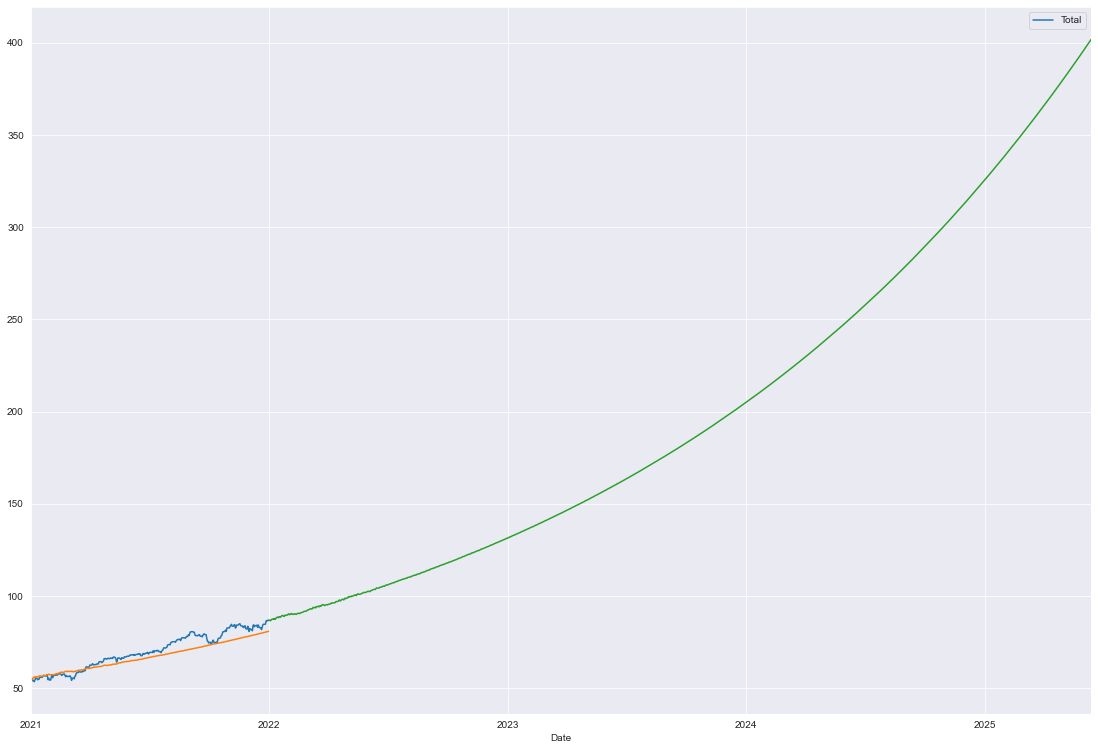

In [117]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 170).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [118]:
forecast

2021-12-31     86.969164
2022-01-01     87.019742
2022-01-02     86.667386
2022-01-03     86.665736
2022-01-04     87.211744
                 ...    
2025-06-09    399.899008
2025-06-10    400.419557
2025-06-11    400.942028
2025-06-12    401.461814
2025-06-13    401.979426
Freq: D, Length: 1261, dtype: float64

In [119]:
forecast_df = pd.DataFrame(forecast)

In [120]:
forecast_df

,0
2021-12-31,86.969164
2022-01-01,87.019742
2022-01-02,86.667386
2022-01-03,86.665736
2022-01-04,87.211744
...,...
2025-06-09,399.899008
2025-06-10,400.419557
2025-06-11,400.942028
2025-06-12,401.461814


In [121]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [122]:
return_series

,0
2021-12-31,NaN
2022-01-01,0.000582
2022-01-02,-0.003470
2022-01-03,-0.003489
2022-01-04,0.002789
...,...
2025-06-09,3.598170
2025-06-10,3.604156
2025-06-11,3.610163
2025-06-12,3.616140


In [123]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1/5))-1

print(annualized_return*100)

                    0
2025-06-13  35.821245
